In [11]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from stochastic_dynamics.models import DeepLagEmbed, ARMLP, ARTransformer, AnalyticalAR
from stochastic_dynamics.generators import tvar
from stochastic_dynamics.utils import train_loop, bench_loop
from stochastic_dynamics.plottings import plot_history, plot_coefficients_by_p, plot_tvar_sample

from torchinfo import summary

In [13]:
d

NpzFile 'model/novak_data.npz' with keys: X, A, p_true, class_id, class_names...

In [15]:
f = np.load('model/tvar_dataset.npz')
f

NpzFile 'model/tvar_dataset.npz' with keys: X_train, coef_train, p_train, X_val, coef_val...

In [ ]:
d = np.load('model/novak_data.npz')
X_train, coef_train, \
    p_train, X_val, coef_val, p_val = [d[k][:] for k in ['X_train', 'coef_train', 
                                                      'p_train', 'X_val', 'coef_val', 'p_val']]
d.close()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    torch.cuda.init()
print(f"Using device: {device}")

# To tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
p_train = torch.tensor(p_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
p_val = torch.tensor(p_val, dtype=torch.long)
train_loader = DataLoader(TensorDataset(X_train, p_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, p_val), batch_size=32)

Using device: cuda


In [ ]:
def do_bench_on_config(lambda_config):
    
    # hyperparameters
    n_epochs = 20
    lr = 1e-3
    max_ar_order = 6
    

    # Model: n_classes=5 for p∈{2,3,4,5,6}, max_ar_order=6 for coefficient dimensions
    # model = DeepLagEmbed(seq_len=600, n_classes=5, max_ar_order=6, hidden_dim=128)
    # model = DeepLagEmbed(seq_len=600, n_classes=5, max_ar_order=6, hidden_dim=128)
    # model = ARMLP(seq_len=600, n_classes=5, max_ar_order=6, hidden_dim=128)
    # model = ARTransformer(seq_len=600, n_classes=5, max_ar_order=6, d_model=64, nhead=4, num_layers=2)
    model = AnalyticalAR(seq_len=600, n_classes=5, max_ar_order=6)
    model = model.to(device)

    # summary(model, input_size=(32, 600), device=device)

    # Train
    history = train_loop(
        model, train_loader, val_loader,
        n_epochs=n_epochs, lr=lr,
        lambda_p=lambda_config["lambda_p"], 
        lambda_ar=lambda_config["lambda_ar"], 
        lambda_energy=lambda_config["lambda_energy"],
        lambda_smooth=lambda_config["lambda_smooth"], 
        lambda_order=lambda_config["lambda_order"],
        p_max=max_ar_order, device=device
    )
    return model, history

Training: 100%|██████████| 20/20 [00:19<00:00,  1.01it/s, p_acc=0.201, train=0.0758, val=0.0760]


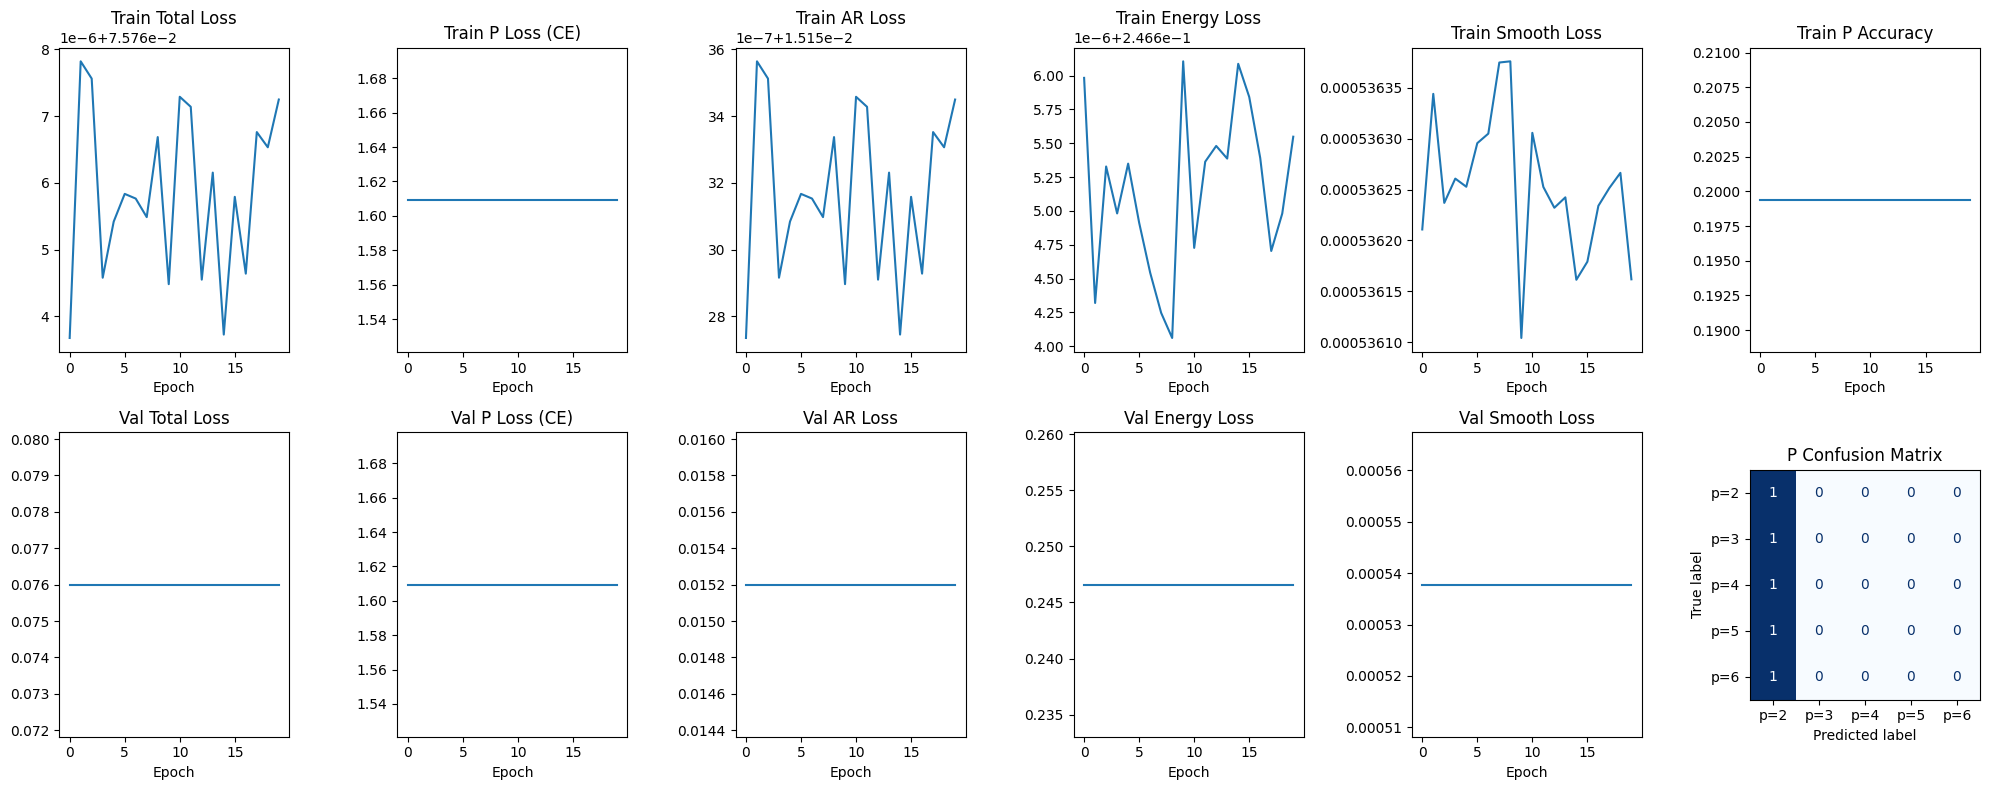

coeff_mse: 0.010076573301618024
signal_mse: 0.01521340012550354
p2_acc: 1.0
p3_acc: 0.0
p4_acc: 0.0
p5_acc: 0.0
p6_acc: 0.0
p_acc: 0.201


In [ ]:
# embed_config = {
#     "lambda_ar": 5.0,
#     "lambda_p": 4.0,
#     "lambda_order": 0,
#     "lambda_energy": 0.1,
#     "lambda_smooth": 3
# }

config = {
    "lambda_ar": 5.0,
    "lambda_p": 0,
    "lambda_order": 0,
    "lambda_energy": 0,
    "lambda_smooth": 0
}
model, history = do_bench_on_config(config)
plot_history(history, model=model, val_loader=val_loader, device=device)
full_bench_results = bench_loop(model, X_val, coef_val, p_val, device)
for k, v in full_bench_results.items():
    print(f"{k}: {v}")

In [ ]:
# import pandas as pd

# ablation_df = pd.DataFrame({
#     'full': full_bench_results,
#     'no_ar': no_ar_bench_results,
#     'no_p': no_p_bench_results,
#     'no_energy': no_energy_bench_results,
#     'no_smooth': no_smooth_bench_results
# }).T

# ablation_df